# Extracting tables from invoices

In [9]:
# Open the PDF file
pdf_path = 'invoice-sample.pdf'

In [13]:
import os 
print(os.environ.get('JAVA_HOME'))

None


In [21]:
java_home = 'C:\Program Files\Java\jdk-17.0.2'

# Set the JAVA_HOME environment variable
os.environ['JAVA_HOME'] = java_home

# Update the PATH to include the Java bin directory
os.environ['PATH'] = os.path.join(java_home, 'bin') + os.pathsep + os.environ['PATH']

In [22]:
print(os.environ['PATH'])

C:\Program Files\Java\jdk-17.0.2\bin;C:\Users\lenovo\anaconda3;C:\Users\lenovo\anaconda3\Library\mingw-w64\bin;C:\Users\lenovo\anaconda3\Library\usr\bin;C:\Users\lenovo\anaconda3\Library\bin;C:\Users\lenovo\anaconda3\Scripts;C:\Users\lenovo\AppData\Local\Tesseract-OCR;C:\Users\lenovo\AppData\Local\Tesseract-OCR;C:\Users\lenovo\AppData\Local\Programs\Microsoft VS Code\bin


In [23]:
from tabula import read_pdf
from tabulate import tabulate

In [24]:
df = read_pdf(pdf_path ,pages="all") 

In [25]:
print(tabulate(df[0])) #first dataframe: first page
print(tabulate(df[1]))

-  ------------  ----------------
0  Order Number  12345
1  Invoice Date  January 25, 2016
2  Due Date      January 31, 2016
3  Total Due     $93.50
-  ------------  ----------------
-  -  -------------------------------  ------  -----  ------
0  1  Web Design                       $85.00  0.00%  $85.00
      This is a sample description...
-  -  -------------------------------  ------  -----  ------


# Identifying layouts of Invoices to apply OCR

In [26]:
import cv2
import pytesseract
from pytesseract import Output

In [27]:
img = cv2.imread('invoice-sample.jpg')

In [28]:
d = pytesseract.image_to_data(img, output_type=Output.DICT)
# Print the keys of the resulting dictionary to see the available information
print(d.keys())

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


In [30]:
n_boxes = len(d['text']) #bounding boxes 
for i in range(n_boxes):
    if float(d['conf'][i]) > 60:  # Check if confidence score is greater than 60
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

cv2.imshow('img', img)
cv2.waitKey(0)

-1

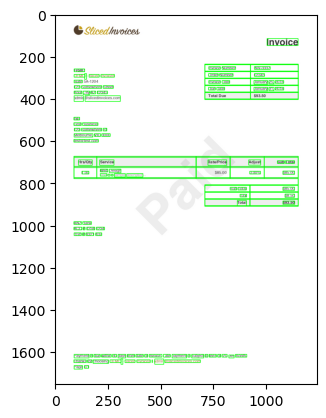

In [34]:
from matplotlib import pyplot as plt
plt.imshow(img)

# Invoice Extraction using NER

In [35]:
import spacy
# Load the English pre-trained model with NER
nlp = spacy.load('en_core_web_sm')

In [41]:
!pip install pdfplumber

  Obtaining dependency information for pdfplumber from https://files.pythonhosted.org/packages/c1/f9/1a41afffe5e7a98ab9b6a6dd3dab9d99b677fae2536f676397c4506f6554/pdfplumber-0.10.2-py3-none-any.whl.metadata
     ---------------------------------------- 5.6/5.6 MB 4.7 MB/s eta 0:00:00
  Obtaining dependency information for pypdfium2>=4.18.0 from https://files.pythonhosted.org/packages/6f/87/e4f8a898a8c06ea9efc8be41a7c8fc8dcab8cab6931c02f5a2f686ed9542/pypdfium2-4.18.0-py3-none-win_amd64.whl.metadata
     ---------------------------------------- 41.3/41.3 kB ? eta 0:00:00
   ---------------------------------------- 47.5/47.5 kB 2.5 MB/s eta 0:00:00
   ---------------------------------------- 2.7/2.7 MB 5.8 MB/s eta 0:00:00


In [42]:
import pdfplumber

In [43]:
with pdfplumber.open(pdf_path) as pdf:
    for page in pdf.pages:
        text += page.extract_text()

# Apply the NER model to the extracted text
doc = nlp(text)

# Process and analyze the named entities extracted from the text
for ent in doc.ents:
    print(ent.text, ent.label_)

30 days DATE
5% PERCENT
DEMO - Sliced Invoices ORG
DEMO - Sliced Invoices
Suite ORG
5A-1204 CARDINAL
123 CARDINAL
12345 DATE
12345 DATE
January 25, 2016 DATE
Due Date
January 31, 2016 DATE
Total Due WORK_OF_ART
93.50 MONEY
Test Business ORG
123 CARDINAL
Melbourne GPE
3000 CARDINAL
Hrs/Qty
Service
Rate/Price ORG
1.00 CARDINAL
85.00 MONEY
0.00% PERCENT
85.00 MONEY
85.00 MONEY
8.50 MONEY
93.50 MONEY
ANZ Bank ORG
# 1234 1234 DATE
BSB ORG
432 CARDINAL
Paid
Invoice
Invoice Number INV-3337 ORG
DEMO - Sliced Invoices Order ORG
12345 DATE
Suite PERSON
January 25, 2016 DATE
123 CARDINAL
January 31, 2016 DATE
93.50 MONEY
Test Business ORG
123 CARDINAL
St
d
 PERSON
Melbourne GPE
3000 CARDINAL
Hrs/Qty Service Rate/Price Adjust Sub Total ORG
1.00 $85.00 MONEY
0.00% PERCENT
85.00 MONEY
85.00 MONEY
8.50 MONEY
93.50 MONEY
ANZ Bank ORG
# 1234 1234 DATE
BSB ORG
30 days DATE
5% PERCENT
DEMO - Sliced Invoices ORG
1/1 CARDINAL


In [44]:
invoice_number = None
invoice_date = None
total_amount_due = None

for ent in doc.ents:
    if ent.label_ == 'INVOICE_NUMBER':
        invoice_number = ent.text.strip()
    elif ent.label_ == 'DATE':
        if ent.text.strip().lower().startswith('invoice'):
            invoice_date = ent.text.strip()
    elif ent.label_ == 'MONEY':
        if 'total' in ent.text.strip().lower():
            total_amount_due = ent.text.strip()